In [1]:
# MIT image
# Made by : HERO Kwon
# Date : 190108

import os
import numpy as np
import pandas as pd
import pickle
import gzip
import matplotlib.pyplot as plt
import math
import cmath

# data path
#path_meta = '/home/herokwon/mount_data/Data/Wi-Fi_meta/'
#path_csi = '/home/herokwon/mount_data/Data/Wi-Fi_processed/'
#path_csi_np = '/home/herokwon/mount_data/Data/Wi-Fi_processed_npy/'
#path_mit_image = '/home/herokwon/mount_data/Data/Wi-Fi_mit_denoise/'

# data path_mi
path_csi = 'D:\\Data\\Wi-Fi_processed\\'
path_csi_np = 'D:\\Data\\Wi-Fi_processed_npy\\'
path_meta = 'D:\\Data\\Wi-Fi_meta\\'
path_sc = 'D:\\Data\\Wi-Fi_info\\'
path_mit_image = 'D:\\Data\\Wi-Fi_mit_image\\'

# data info
df_info = pd.read_csv(path_meta+'data_subc_sig_v1.csv') # 55429 rows
#df_info = df_info[df_info.id_location==1]

#df_info = df_info.iloc[0:3700]
#df_info = df_info.iloc[3700:7400]
#df_info = df_info.iloc[7400:11100]
#df_info = df_info.iloc[11100:14800]
#df_info = df_info.iloc[14800:18500]
#df_info = df_info.iloc[18500:22200]
#df_info = df_info.iloc[22200:25900]
#df_info = df_info.iloc[25900:29600]
#df_info = df_info.iloc[29600:33300]
#df_info = df_info.iloc[33300:37000]
#df_info = df_info.iloc[37000:40700]
#df_info = df_info.iloc[40700:44400]
#df_info = df_info.iloc[44400:48100]
#df_info = df_info.iloc[48100:51800]
df_info = df_info.iloc[51800:55429]


person_uid = np.unique(df_info['id_person'])
dict_id = dict(zip(person_uid,np.arange(len(person_uid))))
csi_time = 100 #15000 #int(np.max(df_info['len']))
# parameters
max_value = np.max(df_info['max'].values)
#no_classes = len(np.unique(df_info['id_person']))
no_classes = len(dict_id)
csi_subc = 30
input_shape = (csi_time, csi_subc, 6)

# freq BW list
bw_list = pd.read_csv(path_meta+'wifi_f_bw_list.csv')
'''
# avg Array
with open(path_meta + 'dict_avgcsi.pickle','rb') as f:
    dict_avg = pickle.load(f)
'''
# 3D scan param
m,n = 2,3
c =  299792458 # speed of light 
#r = (160 + 160 + 164) * 0.01 # meter
r = 1.64 #meter
d = 45 * 0.01 # meter
ch = 6#3
max_subc = 30


In [2]:
# make data generator
def gen_csi(df_info,id_num,len_num):
    infiles = set([file.replace(".npy","") for file in os.listdir(path_mit_image)])
    tofiles = list(set(np.unique(df_info.id.values)) - infiles)
    for file in tofiles:    
        # Label
        id_key = df_info[df_info.id==file][['id_person','id_location','id_direction','id_exp']].values[0].astype('int')
        data1_y = dict_id[id_key[0]]

        # read sample data
        # load and uncompress.
        with gzip.open(path_csi+file+'.pickle.gz','rb') as f:
            data1 = pickle.load(f)
        data1 = data1**4 / (np.abs(data1)**3)
        s_idx = (np.arange(len_num) * data1.shape[0] / len_num).astype('int')
        dt=np.min([100,len(data1)-s_idx[-1]])
        list_avgt = []
        for idx in s_idx:
            data1_t = data1[idx:idx+dt,:,:,:]
            data1_avgt = np.mean(data1_t,axis=0)
            list_avgt.append(data1_avgt)
        data1_s = np.array(list_avgt)
        # zero pad
        #pad_len = len_num - data1_diff.shape[0]
        #data1_pad = np.pad(data1_diff,((0,pad_len),(0,0),(0,0),(0,0)),'constant',constant_values=0)

        # subcarrier info
        #data1_sc_df = pd.read_csv(path_sc + file + '_df_sc.csv')
        #data1_time = np.diff(data1_sc_df['timestamp_low'])
        #data1_time_pad = np.pad(data1_time,((1,pad_len)),'constant',constant_values=0)

        yield(data1_s ,data1_y,id_key,file)#,data1_time_pad)

gen = gen_csi(df_info,no_classes,csi_time)


In [3]:
# 3D Reconstruction func
from numba import vectorize
@vectorize(['complex64(complex64,float32,float32,int32,int32,float32,float32,float32,int32)'], target='cpu')
def Recon3d(sig,theta,sigma,m,n,lam,d,r,c):
    #above_eq1 = 1j * (2*math.pi) * k * r * t / c
    #above_eq1 = 1j * (2*math.pi) * c * dt * 0.000001 / lam
    above_eq1 = 1j * (2*math.pi) * r / lam
    above_eq2 = 1j * (2*math.pi/lam) * math.sin(theta) * ((n+1)*d*math.cos(sigma) + (m+1)*d*math.sin(sigma))
    eq_res = sig* cmath.exp(above_eq1) * cmath.exp(above_eq2)
    #eq_res = cmath.exp(above_eq1) * cmath.exp(above_eq2)
    return eq_res #math.atan2(eq_res.imag,eq_res.real)


def Calc3d(target_sig,max_subc,theta,sigma,bw_list,ch,d,r,c,m,n):
    #vectorize arrays
    subc_array = np.ones([csi_time,max_subc,m,n])
    m_array = np.ones([csi_time,max_subc,m,n])
    n_array = np.ones([csi_time,max_subc,m,n])
    for i in range(max_subc):
        subc_array[:,i,:,:] = i
    for i in range(m):
        m_array[:,:,i,:] = i
    for i in range(n):
        n_array[:,:,:,i] = i
    subc_array = subc_array.flatten().astype(np.int32)
    m_array = m_array.flatten().astype(np.int32)
    n_array = n_array.flatten().astype(np.int32)
    lam_array = np.array([c*0.000001/bw_list[str(e)][ch] for e in subc_array],dtype=np.float32)
    
    target_array = target_sig.flatten().astype(np.complex64)
    
    #3d recon
    sum_eq = np.zeros(csi_time*max_subc*m*n,dtype=np.complex_)
    sum_eq = Recon3d(target_array,theta,sigma,m_array,n_array,lam_array,d,r,c)

    sum_reshape = np.sum(sum_eq.reshape([-1,max_subc,m,n]),axis=(1,2,3))
    return(np.abs(sum_reshape))


In [4]:
target_sig,target_lab,target_id,target_file = next(gen)
th_range,si_range = (30,30)
list_res = []
for ch in range(13):
    sig_mat = np.zeros([csi_time,2*th_range,2*si_range])

    import time
    t1 = time.time()
    for idx_th,i in enumerate(range(-th_range,th_range)):
        for idx_si,j in enumerate(range(-si_range,si_range)):
            theta = i * (np.radians(60)/2) / th_range
            sigma = j * (np.radians(60)/2) / si_range
            sig_mat[:,idx_th,idx_si] = Calc3d(target_sig,max_subc,theta,sigma,bw_list,ch,d,r,c,m,n)
    print(time.time()-t1)
    #print(f)
    print(target_file)
    print(ch)
    list_res.append(sig_mat)
    #np.save(path_mit_image + f + '.npy',sig_mat)


699.5895280838013
S106_2_4_1
0
695.5988149642944
S106_2_4_1
1
698.6768238544464
S106_2_4_1
2
697.2502830028534
S106_2_4_1
3
696.514506816864
S106_2_4_1
4
697.0323655605316
S106_2_4_1
5
695.4468507766724
S106_2_4_1
6
696.4685332775116
S106_2_4_1
7
697.9970581531525
S106_2_4_1
8
694.8840420246124
S106_2_4_1
9
700.683253288269
S106_2_4_1
10
693.8453583717346
S106_2_4_1
11
695.0600755214691
S106_2_4_1
12


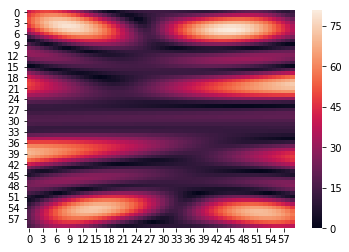

In [25]:
import seaborn as sns
ax = sns.heatmap(sig_mat[12,:,:])

In [6]:
np.save("channel_denoise_debug.npy",sig_mat)

In [7]:
for i in range(13):
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
